<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/linalg_eig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 固有値計算

アーベル・ルフィニの定理より5次以上の代数方程式には公式が存在しない。よって5x5行列の特性方程式は直接的に解けないため、反復法を使用する。

### べき乗法

べき乗法では対象の行列$A$のべき乗で最大固有値とその固有ベクトルを求める

In [1]:
%reset -f

ランダム行列を作成

A=


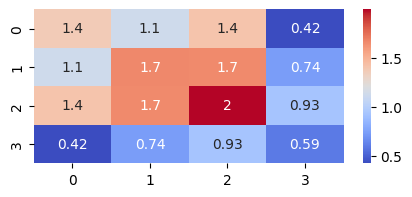

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N = 4
A = np.random.rand(N, N)
# 固有値正を保証
A = A @ A.T
print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

In [3]:
eps=1e-6
max_iter=100

x = (_ := np.random.rand(N)) / np.linalg.norm(_)
lambda_ = 0
for i in range(max_iter):
  # 反復毎に最大固有値の固有ベクトル成分が大きくなる
  v = A @ x
  # 最終的に(x,Ax)=(x,λx)=λとなるはず
  lambda_ = np.dot(x, v)
  x = v / np.linalg.norm(v)
  if np.dot(v, v) - lambda_ ** 2 < eps:
    break

print(f"{i=}")
print(f"{lambda_=:.3}")
print(f"{x=}")
print(f"{A@x-lambda_*x=}")

i=4
lambda_=4.89
x=array([0.465, 0.553, 0.633, 0.278])
A@x-lambda_*x=array([-1.634e-05,  5.703e-06,  1.980e-06,  1.150e-05])


### ハウスホルダー変換

対角成分より2以上左の成分が0となっている行列をヘッセンベルグ行列という。
QR 分解の前処理としてハウスホルダー変換と呼ばれる直交・鏡映変換で、
対象行列をヘッセンベルグ行列へ変換する。

P=


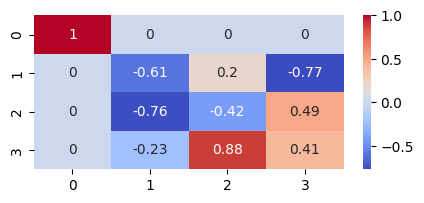

A=


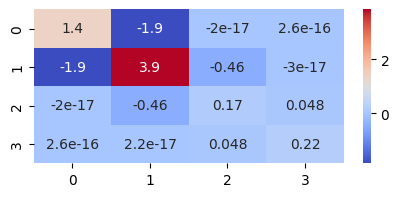

In [4]:
def house(b):
  e = np.zeros_like(b)
  e[0] = 1
  # 桁落ち対策で異符号に
  s = -np.sign(b[0]) * np.linalg.norm(b)
  u = (_ := b - s * e) / np.linalg.norm(_)
  P = np.eye(len(b)) - 2 * np.outer(u, u)
  return P

P = np.eye(N)
for k in range(N - 2):
  x = A[k+1:, k]
  # ハウスホルダー変換
  Pk = np.eye(N)
  Pk[k+1:, k+1:] = house(x)

  A = Pk @ A @ Pk
  P = P @ Pk

print("P=")
sns.heatmap(P, annot=True, cmap='coolwarm')
plt.show()

print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

### QR 分解

最も基本的な QR 分解はグラム・シュミットの直交化を利用

Q=


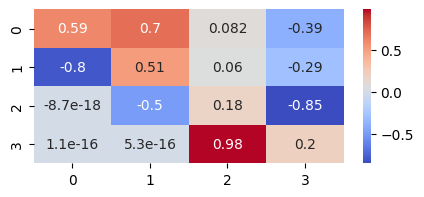

R=


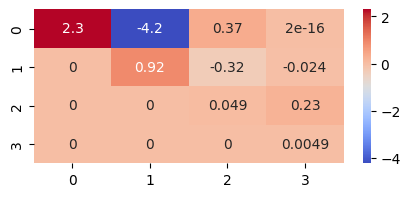

A-QR=


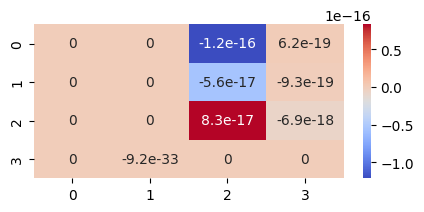

In [5]:
def QR(A_):
  A = A_.copy()
  N = len(A)
  Q = np.zeros_like(A)
  R = np.zeros_like(A)

  for i in range(N):
    # グラム・シュミットの直交化 -> Q を計算
    u = A[:, i]
    for j in range(i):
      u -= np.dot(A[:, i], Q[:, j]) * Q[:, j]
    Q[:, i] = u / np.linalg.norm(u)

    # 上三角行列 R を計算
    for j in range(i, N):
      if i == j:
        vec = A[:, j]
        for k in range(i):
          vec -= np.dot(A[:, j], Q[:, k]) * Q[:, k]
        R[i, j] = np.linalg.norm(vec)
      else:
        R[i, j] = np.dot(A[:, j], Q[:, i])

  return Q, R

Q, R = QR(A)

print("Q=")
sns.heatmap(Q, annot=True, cmap='coolwarm')
plt.show()

print("R=")
sns.heatmap(R, annot=True, cmap='coolwarm')
plt.show()

print("A-QR=")
sns.heatmap(A-Q@R, annot=True, cmap='coolwarm')
plt.show()

## 特異値分解

### 右特異ベクトル

行列 $A$ に対して行列 $A^TA$ を考える。
明らかに $(A^TA)^T=A^TA$ なので対称行列。
[スペクトル定理](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AB%E5%AE%9A%E7%90%86)より固有値は常に実数である。

また行列 $A$ の非負定値の条件は任意の $\vec{x}\neq\vec{0}$ に対して $\vec{x}^TA\vec{x}\geq0$。
よって任意の $A, \vec{x}\neq\vec{0}$ に対して $\vec{x}^T(A^TA)\vec{x}=||A\vec{x}||^2\geq0$。
これより固有値は常に非負である。そのため固有値の平方根も常に実数である。

これは $AA^T$ でも同様に成立。

実際に確かめるために乱数生成の行列でこれを計算。

<Axes: >

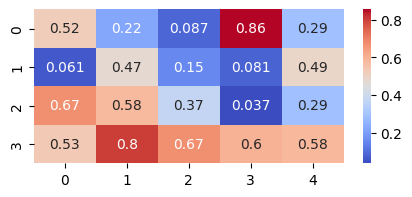

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N, M = 4, 5
A = np.random.rand(N, M)
sns.heatmap(A, annot=True, cmap='coolwarm')

$A^TA$ は対称行列

<Axes: >

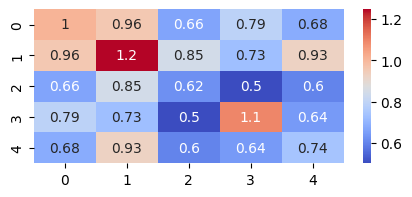

In [7]:
ATA = A.T @ A
sns.heatmap(ATA, annot=True, cmap='coolwarm')

固有値はすべて実数で非負（数値誤差に注意）

w_right=array([ 3.943e+00,  5.212e-01,  1.936e-01,  5.720e-02, -8.347e-17])


<Axes: >

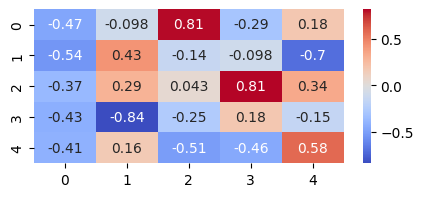

In [8]:
import numpy.linalg as la

w_right, V = la.eigh(ATA)
# 固有値が大きい順
w_right, V = w_right[::-1], V[:, ::-1]
print(f"{w_right=}")
sns.heatmap(V, annot=True, cmap='coolwarm')

固有ベクトルは$V$の各列が対応。
検算で $\vec{v}^T(A^TA)\vec{v}-w$ を計算。

<Axes: >

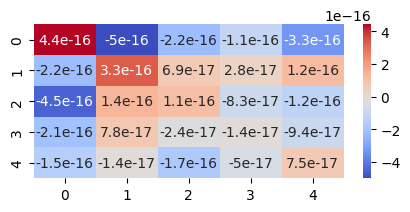

In [9]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

$V$ 行列は直交行列(ユニタリー行列)で[右特異ベクトル](https://manabitimes.jp/math/1280#5)

In [ ]:
import seaborn as sns

# 検算。ユニタリなら単位行列に近くなる。
sns.heatmap(V.T @ V, annot=True, cmap='coolwarm')

### 左特異ベクトル

同様に $AA^T$ について計算し左特異ベクトル$U$を求める

In [ ]:
AAT = A @ A.T
w_left, U = la.eigh(AAT)
# 固有値が大きい順
w_left, U = w_left[::-1], U[:, ::-1]

print(f"{w_left=}")
sns.heatmap(U, annot=True, cmap='coolwarm')

左特異ベクトルを検算

In [ ]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

In [ ]:
sns.heatmap(U.T @ U, annot=True, cmap='coolwarm')

### 特異値分解

数値誤差の対策。ほぼ0は0とする。

In [ ]:
w_right = np.array([w if abs(w) > 1e-10 else 0 for w in w_right])
w_left = np.array([w if abs(w) > 1e-10 else 0 for w in w_left])
print(f"{w_right=}")
print(f"{w_left=}")

$A^TA, AA^T$ の固有値の平方根は特異値

In [ ]:
sigma_right = np.sqrt(w_right)
sigma_left = np.sqrt(w_left)
print(f"{sigma_right=}")
print(f"{sigma_left=}")

特異値による行列 $\Sigma$ を作成

In [ ]:
Sigma = np.zeros_like(A)
sigma = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma[:len(sigma), :len(sigma)] = np.diag(sigma)
print(f"{Sigma=}")

固有ベクトルには符号の不定性があるためそのままでは$A=U\Sigma V^T$を満たすとは限らない。

$\Sigma$の成分は非負なので$(AV)_i=\lambda_iU_i, \lambda_i\geq0$。
そこでこの[条件を満たすように符号の反転をする](
https://math.stackexchange.com/questions/4844816/discrepancies-in-custom-svd-implementation-compared-to-np-linalg-svd-sign-issu)。

In [ ]:
U = np.array([np.sign(np.dot(A @ V[:, idx], U[:, idx])) * U[:, idx]
    for idx in range(U.shape[1])]).T
sns.heatmap(U, annot=True, cmap='coolwarm')

[特異値分解](https://manabitimes.jp/math/1280#5) $A=U\Sigma V^T$ の検算。

In [ ]:
residuals = A - (U @ Sigma @ V.T)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

numpy の標準機能でも特異値分解。

In [ ]:
U2, sigma2, V2h = la.svd(A)
print(sigma2)

特異ベクトルは符号の不定性があるため、対角化から求めた結果と一致するとは限らない。

In [ ]:
import matplotlib.pyplot as plt

print(f"{sigma2-sigma=}")
sns.heatmap(U-U2, annot=True, cmap='coolwarm')
plt.show()
sns.heatmap(V.T - V2h, annot=True, cmap='coolwarm')
plt.show()

特異分解$A=U\Sigma V^T$はきちんと満たす。

In [ ]:
Sigma2 = np.zeros_like(A)
sigma2 = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma2[:len(sigma2), :len(sigma2)] = np.diag(sigma2)
residuals = A - (U2 @ Sigma2 @ V2h)
sns.heatmap(residuals, annot=True, cmap='coolwarm')